### Data cleanup

This notebook is meant for cleaning up the donation data.

The following is a summary of some of the cleanup tasks from this notebook:

1. Load the csv file that has the donors
2. Strip out whitespace from all the columns
3. Fill na with empty strings
4. Change column data types (after examining for correctness)
5. Cleanup amounts column - removed negative (totals to -641910.46 dollars) and zero values
6. Cleanup state codes.
7. Removed donations that are outside of US - about \$30,000 USD
8. Removed donations totaling to 9.5 million dollars that came from anonymous donors (as outliers)
9. If there is no location information or it is inaccurate, move it to a different, move it to a different dataframe
10. Update the city and state names when not present based on the zipcodes dataset.

In [1]:
import pandas as pd
import numpy as np
import locale
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, HoverTool

%matplotlib inline
from bokeh.plotting import output_notebook
output_notebook()

Loading BokehJS ...

In [2]:
_ = locale.setlocale(locale.LC_ALL, '')
thousands_sep = lambda x: locale.format("%.2f", x, grouping=True)
#example:
print thousands_sep(1234567890.76543)

getdate_ym = lambda x: str(x.year) + "_" + str(x.month)
getdate_ymd = lambda x: str(x.month) + "/" + str(x.day) + "/" + str(x.year)
dates = pd.DatetimeIndex(['2010-10-17', '2011-05-13', "2012-01-15"])
map(getdate_ym, dates)
map(getdate_ymd, dates)

1,234,567,890.77


['10/17/2010', '5/13/2011', '1/15/2012']

## Load csv

In [3]:
df = pd.read_csv('in/gifts_Feb2016_2.csv')
source_columns = ['donor_id', 'amount_initial', 'donation_date', 'appeal', 'fund', 'city', 'state', 'zipcode_initial', 'charitable', 'sales']
df.columns = source_columns

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240015 entries, 0 to 240014
Data columns (total 10 columns):
donor_id           240015 non-null object
amount_initial     240015 non-null object
donation_date      240015 non-null object
appeal             239989 non-null object
fund               240014 non-null object
city               240015 non-null object
state              240015 non-null object
zipcode_initial    240015 non-null object
charitable         240015 non-null int64
sales              240015 non-null int64
dtypes: int64(2), object(8)
memory usage: 12.8+ MB


In [5]:
strip_func = lambda x: x.strip() if isinstance(x, str) else x
df = df.applymap(strip_func)

### Address nan column values

In [6]:
df.replace({'appeal': {'0': ''}}, inplace=True)
df.appeal.fillna('', inplace=True)
df.fund.fillna('', inplace=True)

## Change column types and drop unused columns

In [7]:
df.donation_date = pd.to_datetime(df.donation_date)
df.charitable = df.charitable.astype('bool')
df['zipcode'] = df.zipcode_initial.str[0:5]

In [8]:
fill_zipcode = lambda x: '0'*(5-len(str(x))) + str(x)
x1 = pd.DataFrame([[1, '8820'], [2, 8820]], columns=['a','b'])
x1.b = x1.b.apply(fill_zipcode)
x1

,a,b
0,1,08820
1,2,08820


In [9]:
df.zipcode = df.zipcode.apply(fill_zipcode)

## Cleanup amounts

In [10]:
## Ensure that all amounts are dollar figures
df[~df.amount_initial.str.startswith('-$') & ~df.amount_initial.str.startswith('$')]

,donor_id,amount_initial,donation_date,appeal,fund,city,state,zipcode_initial,charitable,sales,zipcode
219085,B909F70A2B,97ACBD2F90,1899-12-31 00:00:00,,,Mosher Dr,San Jose,CA,True,0,000CA


In [11]:
## drop row with invalid data
df.drop(df[df.donation_date == '1899-12-31'].index, axis=0, inplace=True)

In [12]:
df['amount_cleanup'] = df.amount_initial.str.replace(',', '')
df['amount_cleanup'] = df.amount_cleanup.str.replace('$', '')
df['amount'] = df.amount_cleanup.astype(float)

In [13]:
## Make sure we did not throw away valid numbers by checking with the original value
df[(df.amount == 0)].amount_initial.unique()

array(['$0.00'], dtype=object)

## Outlier data

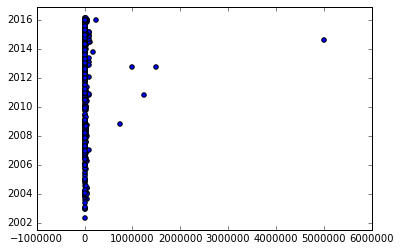

In [14]:
# There are some outliers in the data, quite a few of them are recent.
_ = plt.scatter(df[df.amount > 5000].amount.values, df[df.amount > 5000].donation_date.values)
plt.show()

In [15]:
# Fun little thing to try out bokeh (we can hover and detect the culprits)
def plot_data(df):
    dates = map(getdate_ym, pd.DatetimeIndex(df[df.amount > 5000].donation_date))
    amounts = map(thousands_sep, df[df.amount > 5000].amount)
    x = df[df.amount > 5000].donation_date.values
    y = df[df.amount > 5000].amount.values
    donor_ids = df[df.amount > 5000].donor_id.values
    states = df[df.amount > 5000].state.values

    source = ColumnDataSource(
            data=dict(
                x=x,
                y=y,
                dates=dates,
                amounts=amounts,
                donor_ids=donor_ids,
                states=states,
            )
        )

    hover = HoverTool(
            tooltips=[
                ("date", "@dates"),
                ("amount", "@amounts"),
                ("donor", "@donor_ids"),
                ("states", "@states"),
            ]
        )

    p = figure(plot_width=400, plot_height=400, title=None, tools=[hover])
    p.circle('x', 'y', size=5, source=source)

    show(p)

In [16]:
plot_data(df.query('amount > 5000'))

In [17]:
# All the Outliers seem to have the following properties: state == YY and specific donorid.
# Plot the remaining data outside of these to check that we caught all the outliers.
plot_data(df[~df.index.isin(df.query('state == "YY" and amount > 5000').index)])

In [18]:
# Outlier data
df[(df.state == 'YY') & (df.amount >= 45000)]

,donor_id,amount_initial,donation_date,appeal,fund,city,state,zipcode_initial,charitable,sales,zipcode,amount_cleanup,amount
3381,_0S804O0L4,$750000.00,2008-10-31,Funds_mail,Project_Gujarat,YYYY,YY,YYYY,True,0,0YYYY,750000.00,750000
3427,_0S804O0L4,$45000.00,2010-06-02,Funds_mail,Project_Punjab,YYYY,YY,YYYY,True,0,0YYYY,45000.00,45000
3432,_0S804O0L4,$1250000.00,2010-10-18,Funds_NL,Project_Punjab,YYYY,YY,YYYY,True,0,0YYYY,1250000.00,1250000
3448,_0S804O0L4,$1000000.00,2012-09-12,Funds_DirectDeposit,Funds_Capital Projects,YYYY,YY,YYYY,True,0,0YYYY,1000000.00,1000000
3449,_0S804O0L4,$1500000.00,2012-09-12,Funds_DirectDeposit,Project_Uttarpradesh,YYYY,YY,YYYY,True,0,0YYYY,1500000.00,1500000
3470,_0S804O0L4,$5000000.00,2014-08-07,Telephone,Funds_Capital Projects,YYYY,YY,YYYY,True,0,0YYYY,5000000.00,5000000


In [19]:
df[(df.state == 'YY') & (df.amount >= 45000)]\
    .sort_values(by='amount', ascending=False)\
    .head(6)[source_columns]\
    .to_csv('out/0/outlier_data.csv')

#### Exchanged emails with Anil and confirmed the decision to drop the outlier for the anonymous donor with the 9.5 million dollars.

In [20]:
df.drop(df[(df.state == 'YY') & (df.amount >= 45000)].index, inplace=True)

In [21]:
print 'After dropping the anonymous donor, total amounts from the unknown state as a percentage of all amounts is: '\
    , thousands_sep(100*df[(df.state == 'YY')].amount.sum()/df.amount.sum()), '%'

After dropping the anonymous donor, total amounts from the unknown state as a percentage of all amounts is:  0.07 %


### Amounts with zero values

In [22]:
## Some funds have zero amounts associated with them.
## They mostly look like costs - expense fees, transaction fees, administrative fees
## Let us examine if we can safely drop them from our analysis

df[df.amount_initial == '$0.00'].groupby(['fund', 'appeal'])['donor_id'].count()

fund                appeal              
Cataract Surgery    Bank_ACH                  1
                    Funds_DirectDeposit       1
                    Funds_mail                1
Event_Registration  Event_Walkathon_2008      1
Event_Ticket Money  Event_Dandia              1
Link to Zeros       Funds_LinktoZero        493
                    Funds_Magazine            1
Tax Refund          Funds_LinktoZero          1
Name: donor_id, dtype: int64

#### Dropping rows with zero amounts (after confirmation with SEF office)

In [23]:
df.drop(df[df.amount == 0].index, axis=0, inplace=True)

### Negative amounts

In [24]:
## What is the total amount of the negative?
print 'Total negative amount is: ', df[df.amount < 0].amount.sum()

Total negative amount is:  -688259.87


In [25]:
# Add if condition to make this re-runnable
if df[df.amount < 0].amount.sum() > 0:
    print 'Amounts grouped by fund and appeal, sorted by most negative amounts'
    df[df.amount < 0]\
        .groupby(['fund', 'appeal'])['amount',]\
        .sum()\
        .sort_values(by='amount')\
        .to_csv('out/0/negative_amounts_sorted.csv')

    df[df.amount < 0]\
        .groupby(['fund', 'appeal'])['amount',]\
        .sum()\
        .to_csv('out/0/negative_amounts_grouped_by_fund.csv')

#### Dropping rows with negative amounts (after confirmation with SEF office)

In [26]:
df.drop(df[df.amount < 0].index, axis=0, inplace=True)

## Investigate invalid state codes

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 237877 entries, 0 to 240014
Data columns (total 13 columns):
donor_id           237877 non-null object
amount_initial     237877 non-null object
donation_date      237877 non-null datetime64[ns]
appeal             237877 non-null object
fund               237877 non-null object
city               237877 non-null object
state              237877 non-null object
zipcode_initial    237877 non-null object
charitable         237877 non-null bool
sales              237877 non-null int64
zipcode            237877 non-null object
amount_cleanup     237877 non-null object
amount             237877 non-null float64
dtypes: bool(1), datetime64[ns](1), float64(1), int64(1), object(9)
memory usage: 15.7+ MB


In [28]:
df.state.unique()

array(['', 'CA', 'NJ', 'TX', 'VA', 'WA', 'IL', 'KY', 'DE', 'NY', 'TN',
       'WI', 'FL', 'MA', 'GA', 'NC', 'MI', 'PA', 'AZ', 'MD', 'OK', 'NH',
       'CT', 'OH', 'OR', 'KS', 'MT', 'YY', 'MS', 'CO', 'MN', 'ID', 'NV',
       'AP', 'IN', 'MO', 'NE', 'LA', 'ON', 'AL', 'SD', 'AR', 'IA', 'ND',
       'SC', 'UT', 'HY', 'DC', 'ME', 'HI', 'UK', 'VI', 'NM', 'RI', 'WY',
       'PR', 'AB', 'WV', 'CF', 'AK', 'VT', 'Co', 'Ny', 'ja', 'Ca', 'BC',
       '56', 'IO'], dtype=object)

In [29]:
## States imported from http://statetable.com/
states = pd.read_csv('in/state_table.csv')
states.rename(columns={'abbreviation': 'state'}, inplace=True)

In [30]:
all_states = pd.merge(states, pd.DataFrame(df.state.unique(), columns=['state']), on='state', how='right')
invalid_states = all_states[pd.isnull(all_states.id)].state

In [31]:
df[df.state.isin(invalid_states)].state.value_counts().sort_index()

      13750
56        1
AB        1
AP       17
BC        1
CF        1
Ca        1
Co        1
HY        1
IO        1
Ny        5
ON       62
PR        5
UK        1
VI        6
YY      267
ja        1
Name: state, dtype: int64

In [32]:
df[df.state.isin(['56', 'AB', 'BC', 'CF', 'Ca', 'Co', 'HY', 'IO', 'Ny', 'PR', 'UK', 'VI', 'ja'])]

,donor_id,amount_initial,donation_date,appeal,fund,city,state,zipcode_initial,charitable,sales,zipcode,amount_cleanup,amount
36809,_16D0ZPFVU,$30.00,2004-02-20,Funds_Web,Cataract Surgery,Shivam Road,HY,500044,True,0,50004,30.00,30
62847,_1LZ0QH4BH,$300.00,2005-09-19,Funds_mail,Cataract Surgery,"London, England",UK,W93EF,True,0,W93EF,300.00,300
62974,_1M60X2OEP,$10000.00,2005-09-16,Funds_Volunteer,Project_Gujarat,Christiansted,VI,00821-1042,True,0,00821,10000.00,10000
62975,_1M60X2OEP,$1000.00,2008-08-21,Funds_Volunteer,Project_Gujarat,Christiansted,VI,00821-1042,True,0,00821,1000.00,1000
62976,_1M60X2OEP,$1000.00,2008-08-21,Funds_Volunteer,Project_Gujarat,Christiansted,VI,00821-1042,True,0,00821,1000.00,1000
62977,_1M60X2OEP,$1000.00,2008-08-21,Funds_Volunteer,Project_Gujarat,Christiansted,VI,00821-1042,True,0,00821,1000.00,1000
62978,_1M60X2OEP,$1000.00,2008-08-21,Funds_Volunteer,Project_Gujarat,Christiansted,VI,00821-1042,True,0,00821,1000.00,1000
80316,_1TB0VOC6W,$434.00,2006-06-01,Funds_mail,Cataract Surgery,Condado,PR,00907-1627,True,0,00907,434.00,434
86200,_1WG0TMRWC,$1001.00,2006-09-28,Funds_Akka2006_Event,Project_Bangalore,Calgary Canada,AB,T3A4W2,True,0,T3A4W,1001.00,1001
106207,_24410PTQD,$30.00,2007-06-24,Booth_AAPI_2007,Cataract Surgery,Boca Raton,CF,33498-4811,True,0,33498,30.00,30


In [33]:
%%html
<style>table {float:left}</style>

### Explanation for invalid state codes:

State|Count|Action|Explanation|
-----|-----|------|-----------|
YY|268|None|All these rows are bogus entries (City and Zip are also YYYYs) - about 20% of the donation amount has this
ON|62|Remove|This is the state of Ontario, Canada
AP|18|Remove|This is data for Hyderabad
VI|6|Remove|Virgin Islands
PR|5|Remove|Peurto Rico
Ny|5|NY|Same as NY - rename Ny as NY
56|1|Remove|This is one donation from Bangalore, Karnataka
HY|1|Remove|Hyderabad
BC|1|Remove|British Columbia, Canada
IO|1|IA|Changed to Iowa - based on city and zip code
AB|1|Remove|AB stands for Alberta, Canada
Ca|1|CA|Same as California - rename Ca to CA
Co|1|CO|Same as Colarado - rename Co to CO
CF|1|FL|Changed to Florida based on zip code and city
ja|1|FL|Change to FL based on zip code and city
UK|1|Remove|London, UK
KA|1|Remove|Bangalore, Karnataka

In [34]:
state_renames = {'Ny': 'NY', 'IO': 'IA', 'Ca' : 'CA', 'Co' : 'CO', 'CF' : 'FL', 'ja' : 'FL'}
df.replace({'state': state_renames}, inplace=True)

### Dropping data for non-US locations

In [35]:
non_usa_states = ['ON', 'AP', 'VI', 'PR', '56', 'HY', 'BC', 'AB', 'UK', 'KA']
print 'Total amount for locations outside USA: ', sum(df[df.state.isin(non_usa_states)].amount)
#### Total amount for locations outside USA:  30710.63

Total amount for locations outside USA:  30710.63


In [36]:
df.drop(df[df.state.isin(non_usa_states)].index, axis=0, inplace=True)

### Investigate donations with state of YY

In [37]:
print 'Percentage of amount for unknown (YY) state : {:.2f}'.format(100*df[df.state == 'YY'].amount.sum()/df.amount.sum())

Percentage of amount for unknown (YY) state : 0.07


In [38]:
print 'Total amount for the unknown state excluding outliers: ', df[(df.state == 'YY') & (df.amount < 45000)].amount.sum()
print 'Total amount for the unknown state: ', df[(df.state == 'YY')].amount.sum()
print 'Total amount: ', df.amount.sum()

Total amount for the unknown state excluding outliers:  33822.33
Total amount for the unknown state:  33822.33
Total amount:  45113291.39


#### We will add these donations to the noloc_df below (which is the donations that have empty strings for the city/state/zipcode.

## Investigate empty city, state and zip code

Pecentage of total amount from donations with no location:  3.087

#### Moving all the data with no location to a different dataframe.
We will investigate the data that does have location information for correctness of location and then merge the no location data back at the end.

In [39]:
print 'Pecentage of total amount from donations with no location: ', 100*sum(df[(df.city == '') & (df.state == '') & (df.zipcode_initial == '')].amount)/sum(df.amount)

Pecentage of total amount from donations with no location:  3.50179796536


In [40]:
noloc_df = df[(df.city == '') & (df.state == '') & (df.zipcode_initial == '')].copy()
df = df[~((df.city == '') & (df.state == '') & (df.zipcode_initial == ''))].copy()

In [41]:
print df.shape[0] + noloc_df.shape[0]

237782


In [42]:
noloc_df = noloc_df.append(df[(df.state == 'YY')])
df = df[~(df.state == 'YY')]

In [43]:
# Verify that we transferred all the rows over correctly. This total must match the total from above.
print df.shape[0] + noloc_df.shape[0]

237782


## Investigate City in ('YYY','yyy')

These entries have invalid location information and will be added to the noloc_df dataframe.

In [44]:
noloc_df = noloc_df.append(df[(df.city.str.lower() == 'yyy') | (df.city.str.lower() == 'yyyy')])
df = df[~((df.city.str.lower() == 'yyy') | (df.city.str.lower() == 'yyyy'))]

In [45]:
# Verify that we transferred all the rows over correctly. This total must match the total from above.
print df.shape[0] + noloc_df.shape[0]

237782


## Investigate empty state but non-empty city

Percentage of total amount for data with City but no state:  0.566

In [46]:
print 'Percentage of total amount for data with City but no state: {:.3f}'.format(100*sum(df[df.state == ''].amount)/sum(df.amount))
df[((df.state == '') & (df.city != ''))][['city','zipcode','amount']].sort_values('city', ascending=True).to_csv('out/0/City_No_State.csv')

Percentage of total amount for data with City but no state: 0.566


By visually examining the cities for rows that don't have a state, we can see that all the cities are coming from Canada and India and some from other countries (except two entries). So we will correct these two entries and drop all the other rows as they are not relevant to the USA.

In [47]:
index = df[(df.donor_id == '-28K0T47RF') & (df.donation_date == '2007-11-30') & (df.city == 'Cupertino')].index
df.ix[index,'state'] = 'CA'
index = df[(df.donor_id == '9F4812A118') & (df.donation_date == '2012-06-30') & (df.city == 'San Juan')].index
df.ix[index,'state'] = 'WA'
df.ix[index,'zipcode'] = 98250

In [48]:
# Verified that these remaining entries are for non-US location
print 'Total amount for non-USA location: ', df[((df.state == '') & (df.city != ''))].amount.sum()

Total amount for non-USA location:  233054.97


In [49]:
df.drop(df[((df.state == '') & (df.city != ''))].index, inplace=True)

## Investigate empty city and zipcode but valid US state

Percentage of total amount for data with valid US state, but no city, zipcode: 4.509

Most of this amount (1.7 of 1.8 million) is coming from about 600 donors in California. We already know that about California is a major contributor to donations.

Although, we can do some analytics based on just the US state using this data, it complicates the analysis that does not substantiate the knowledge gain.

Therefore, we are dropping the state column from these rows and moving over this data to the dataset that has no location (the one that we created earlier) to simplify our analysis.

In [50]:
print 'Percentage of total amount for data with valid US state, but no city, zipcode: {:.3f}'.format(100*sum(df[(df.city == '') & (df.zipcode_initial == '')].amount)/sum(df.amount))

Percentage of total amount for data with valid US state, but no city, zipcode: 3.837


In [51]:
# Verify that we transferred all the rows over correctly. This total must match the total from above.
print df.shape[0] + noloc_df.shape[0]

236560


In [52]:
stateonly_df = df[(df.city == '') & (df.zipcode_initial == '')].copy()
stateonly_df.state = ''

## Move the rows with just the state over to the noloc_df dataset
noloc_df = pd.concat([noloc_df, stateonly_df])
df = df[~((df.city == '') & (df.zipcode_initial == ''))].copy()

In [53]:
# Verify that we transferred all the rows over correctly. This total must match the total from above.
print df.shape[0] + noloc_df.shape[0]

236560


In [54]:
print 100*sum(df[df.city == ''].amount)/sum(df.amount)

print len(df[df.city == '']), len(df[df.zipcode_initial == ''])
print sum(df[df.city == ''].amount), sum(df[df.zipcode_initial == ''].amount)
print sum(df[(df.city == '') & (df.zipcode_initial != '')].amount),\
    sum(df[(df.city != '') & (df.zipcode_initial == '')].amount)

print sum(df.amount)

0.0407861591339
173 18
16968.3 13004.95
16968.3 13004.95
41603083.89


## Investigating empty city and empty state with non-empty zip code

Since we have the zip code data from the US census data, we can use that to fill in the city and state

In [55]:
## Zip codes from ftp://ftp.census.gov/econ2013/CBP_CSV/zbp13totals.zip
zipcodes = pd.read_csv('in/zbp13totals.txt', dtype={'zip': object})
zipcodes = zipcodes[['zip', 'city', 'stabbr']]
zipcodes = zipcodes.rename(columns = {'zip':'zipcode', 'stabbr': 'state', 'city': 'city'})
zipcodes.city = zipcodes.city.str.title()
zipcodes.zipcode = zipcodes.zipcode.astype('str')

In [56]:
## If we know the zip code, we can populate the city by using the zipcodes data
df.replace({'city': {'': np.nan}, 'state': {'': np.nan}}, inplace=True)

## Set the index correctly for update to work. Then reset it back.
df.set_index(['zipcode'], inplace=True)
zipcodes.set_index(['zipcode'], inplace=True)

df.update(zipcodes, join='left', overwrite=False, raise_conflict=False)

In [57]:
df.reset_index(drop=False, inplace=True)
zipcodes.reset_index(drop=False, inplace=True)

In [58]:
zipcodesdetail = pd.read_csv('in/zip_code_database.csv')

In [59]:
zipcodesdetail = zipcodesdetail[zipcodesdetail.country == 'US'][['zip', 'primary_city', 'county', 'state', 'timezone', 'latitude', 'longitude']]
zipcodesdetail = zipcodesdetail.rename(columns = {'zip':'zipcode', 'primary_city': 'city'})

In [60]:
# The zip codes dataset has quite a few missing values. Filling in what we need for now.
# If this happens again, search for a different data source!!
zipcodesdetail.loc[(zipcodesdetail.city == 'Frisco') & (zipcodesdetail.state == 'TX') & (pd.isnull(zipcodesdetail.county)), 'county'] = 'Denton'

In [61]:
# Strip the ' County' portion from the county names
def getcounty(county):
    if pd.isnull(county):
        return county
    elif county.endswith(' County'):
        return county[:-7]
    else:
        return county

zipcodesdetail.county = zipcodesdetail['county'].apply(getcounty)

In [62]:
zipcodesdetail.zipcode = zipcodesdetail.zipcode.apply(fill_zipcode)

In [63]:
newcols = np.array(list(set(df.columns).union(zipcodesdetail.columns)))

In [64]:
df = pd.merge(df, zipcodesdetail, on=['state', 'city', 'zipcode'], how='inner', suffixes=('_x', ''))[newcols]

In [65]:
# For some reason, the data types are being reset. So setting them back to their expected data types.
df.donation_date = df.donation_date.apply(pd.to_datetime)
df.charitable = df.charitable.apply(bool)
df.amount = df.amount.apply(int)

## Investigate invalid zip codes

In [66]:
all_zipcodes = pd.merge(df, zipcodes, on='zipcode', how='left')
all_zipcodes[pd.isnull(all_zipcodes.city_x)].head()

,donation_date,city_x,fund,amount_initial,amount_cleanup,zipcode,longitude,sales,county,charitable,amount,state_x,donor_id,timezone,latitude,zipcode_initial,appeal,city_y,state_y


In [67]:
## There seems to be only one row with an invalid zip code. Let's drop it.
df.drop(df[df.zipcode_initial.isin(['GU214ND','94000'])].index, axis=0, inplace=True)

## Final check on all location data to confirm that we have no rows with empty state, city or location

In [68]:
print 'No state: count of rows: ', len(df[df.state == ''].amount),\
      'Total amount: ', sum(df[df.state == ''].amount)
print 'No zipcode: count of rows: ', len(df[df.zipcode == ''].amount),\
      'Total amount: ', sum(df[df.zipcode == ''].amount)
print 'No city: count of rows: ', len(df[df.city == ''].amount),\
      'Total amount: ', sum(df[df.city == ''].amount)

No state: count of rows:  0 Total amount:  0
No zipcode: count of rows:  0 Total amount:  0
No city: count of rows:  0 Total amount:  0


In [69]:
# Examining data - top 10 states by amount and number of donors
print df.groupby('state')['amount',].sum().sort_values(by='amount', ascending=False)[0:10]
print df.groupby('state')['donor_id',].count().sort_values(by='donor_id', ascending=False)[0:10]

         amount
state          
CA     20843907
NJ      3429857
WA      3051742
NY      2950386
TX      2853985
IL       985315
PA       639535
FL       582481
MI       454949
VA       408576
       donor_id
state          
CA       109435
NJ        20900
WA        20350
NY        10994
TX         9756
IL         6867
PA         4300
VA         2767
NC         2024
AZ         1931


In [70]:
print noloc_df.state.unique()
print noloc_df.city.unique()
print noloc_df.zipcode.unique()

['' 'YY' 'CA']
['' 'YYYY' 'YY' 'YYYYY' 'YYY' 'yyy']
['00000' '0YYYY' '000YY' '00YYY']


In [71]:
noloc_df['city'] = ''
noloc_df['state'] = ''
noloc_df['zipcode'] = ''

In [72]:
print df.shape[0] + noloc_df.shape[0]

226140


In [73]:
df.shape, noloc_df.shape

((207335, 17), (18805, 13))

In [74]:
# The input data has the latest zip code for each donor. So we cannot observe any movement even if there was any since
# all donations by a given donor will only have the same exact zipcode.
x1 = pd.DataFrame(df.groupby(['donor_id','zipcode']).zipcode.nunique())
x1[x1.zipcode != 1]

,,zipcode
donor_id,zipcode,


In [75]:
# The noloc_df and the df with location values have no donors in common - so we cannot use the donor
# location information from df to detect the location in noloc_df.
set(df.donor_id.values).intersection(noloc_df.donor_id.values)

set()

In [76]:
df.rename(columns={'donation_date': 'activity_date'}, inplace=True)
df['activity_year'] = df.activity_date.apply(lambda x: x.year)
df['activity_month'] = df.activity_date.apply(lambda x: x.month)
df['activity_dow'] = df.activity_date.apply(lambda x: x.dayofweek)
df['activity_ym'] = df['activity_date'].map(lambda x: 100*x.year + x.month)
df['activity_yq'] = df['activity_date'].map(lambda x: 10*x.year + (x.month-1)//3)
df['activity_ymd'] = df['activity_date'].map(lambda x: 10000*x.year + 100*x.month + x.day)

In [77]:
# Drop the zipcode_initial (for privacy reasons)
df.drop('zipcode_initial', axis=1, inplace=True)

### All done! Let's save our dataframes for the next stage of processing

In [78]:
!mkdir -p out/0
df.to_pickle('out/0/donations.pkl')
noloc_df.to_pickle('out/0/donations_noloc.pkl')

In [79]:
df[df.donor_id == '_1D50SWTKX'].sort_values(by='activity_date').tail()

,activity_date,city,fund,amount_initial,amount_cleanup,zipcode,longitude,sales,county,charitable,...,donor_id,timezone,latitude,appeal,activity_year,activity_month,activity_dow,activity_ym,activity_yq,activity_ymd
178547,2015-09-21,Kenmore,Cataract Surgery,$250.00,250.00,98028,-122.24,0,King,True,...,_1D50SWTKX,America/Los_Angeles,47.75,Funds_Givingcampaign,2015,9,0,201509,20152,20150921
178548,2015-11-23,Kenmore,Cataract Surgery,$250.00,250.00,98028,-122.24,0,King,False,...,_1D50SWTKX,America/Los_Angeles,47.75,Funds_Matching,2015,11,0,201511,20153,20151123
178549,2015-11-23,Kenmore,Cataract Surgery,$250.00,250.00,98028,-122.24,0,King,True,...,_1D50SWTKX,America/Los_Angeles,47.75,Funds_Givingcampaign,2015,11,0,201511,20153,20151123
178550,2016-01-26,Kenmore,Project_MadhyaPradesh,$200.00,200.00,98028,-122.24,0,King,False,...,_1D50SWTKX,America/Los_Angeles,47.75,Funds_Matching,2016,1,1,201601,20160,20160126
178551,2016-01-26,Kenmore,Cataract Surgery,$200.00,200.00,98028,-122.24,0,King,True,...,_1D50SWTKX,America/Los_Angeles,47.75,Funds_Givingcampaign,2016,1,1,201601,20160,20160126


In [80]:
df.columns

Index([u'activity_date', u'city', u'fund', u'amount_initial',
       u'amount_cleanup', u'zipcode', u'longitude', u'sales', u'county',
       u'charitable', u'amount', u'state', u'donor_id', u'timezone',
       u'latitude', u'appeal', u'activity_year', u'activity_month',
       u'activity_dow', u'activity_ym', u'activity_yq', u'activity_ymd'],
      dtype='object')

In [81]:
df.shape

(207335, 22)